In [1]:
import pandas as pd
import s3fs
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

fs = s3fs.S3FileSystem(
    key=os.getenv("AWS_ACCESS_KEY_ID", "minioadmin"),
    secret=os.getenv("AWS_SECRET_ACCESS_KEY", "minioadmin"),
    client_kwargs={'endpoint_url': os.getenv("AWS_ENDPOINT_URL", "http://localhost:9000")}
)

# Load Silver tables
df_fact_silver = pd.read_parquet("s3://silver/fact_rental.parquet", filesystem=fs)
df_silver_film = pd.read_parquet("s3://silver/dim_film.parquet", filesystem=fs)

print(df_fact_silver.shape, df_silver_film.shape)


(16044, 17) (1000, 10)


In [2]:
# Dimension Film
dim_film = df_silver_film[['film_id', 'title', 'category', 'rental_rate', 'length', 'replacement_cost', 'rating']].copy()

# Si tu veux, tu peux créer aussi d'autres dimensions comme store, customer, category
dim_category = dim_film[['category']].drop_duplicates().reset_index(drop=True)
dim_category['category_id'] = dim_category.index + 1  # crée un ID unique

# Ajouter category_id à dim_film pour relation
dim_film = dim_film.merge(dim_category, on='category', how='left')


In [3]:
# Ajouter les clés dimensions à la fact table
fact_rental = df_fact_silver.merge(
    dim_film[['film_id', 'category_id']],
    on='film_id',
    how='left'
)

# Calculs des indicateurs business
fact_rental['actual_rental_duration'] = (fact_rental['return_date'] - fact_rental['rental_date']).dt.days
fact_rental['rental_yield'] = (fact_rental['rental_rate'] / fact_rental['replacement_cost']) * 100

print(fact_rental.shape)
fact_rental.head(3)


(16044, 18)


,rental_id,rental_date,inventory_id,customer_id,return_date,staff_id,last_update,_ingestion_timestamp,_source_system,film_id,store_id,title,category,rental_rate,replacement_cost,rental_yield,actual_rental_duration,category_id
0,2,2005-05-24 22:54:33,1525,459,2005-05-28 19:40:33,1,2006-02-16 02:30:53,2026-02-03 12:30:38.491740,postgres.dvdrental,333,2,Freaky Pocus,Music,2.99,16.99,17.598587,3.0,7
1,3,2005-05-24 23:03:39,1711,408,2005-06-01 22:12:39,1,2006-02-16 02:30:53,2026-02-03 12:30:38.491740,postgres.dvdrental,373,2,Graduate Lord,Children,2.99,14.99,19.946631,7.0,16
2,4,2005-05-24 23:04:41,2452,333,2005-06-03 01:43:41,2,2006-02-16 02:30:53,2026-02-03 12:30:38.491740,postgres.dvdrental,535,1,Love Suicides,Horror,0.99,21.99,4.502046,9.0,2


In [4]:
# Vérifier les colonnes clés
key_cols = ['rental_id', 'rental_date', 'film_id', 'store_id', 'category_id']
print("All keys present:", set(key_cols).issubset(fact_rental.columns))


All keys present: True


C:\Users\Meschac\AppData\Local\Temp\ipykernel_17232\2012746452.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_films.values, y=top_films.index, palette='magma')


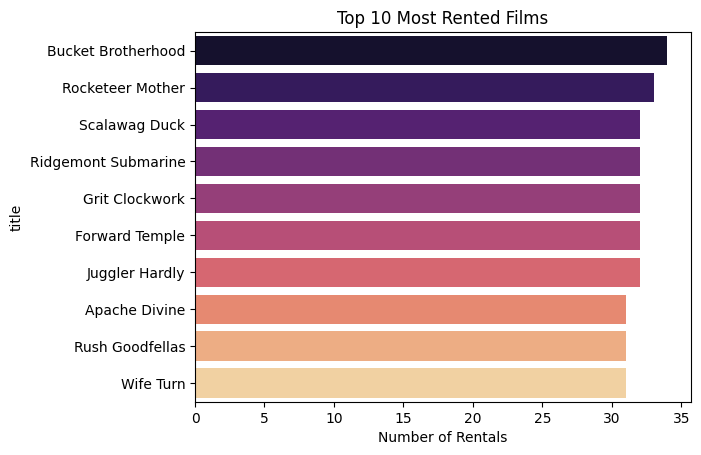

C:\Users\Meschac\AppData\Local\Temp\ipykernel_17232\2012746452.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  yield_by_cat = fact_rental.groupby('category')['rental_yield'].mean().sort_values(ascending=False)
C:\Users\Meschac\AppData\Local\Temp\ipykernel_17232\2012746452.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=yield_by_cat.values, y=yield_by_cat.index, palette='viridis')


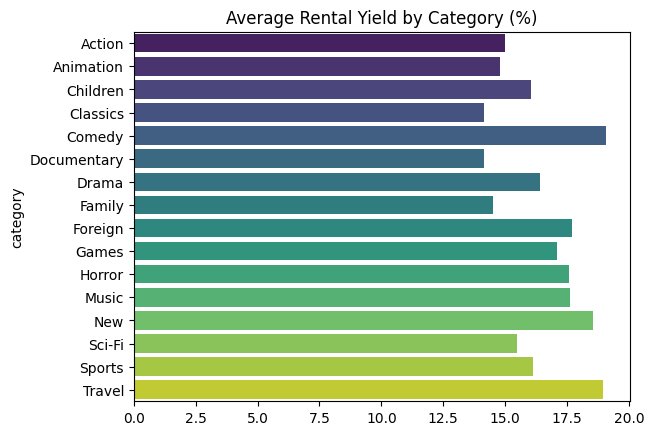

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top 10 films par nombre de locations
top_films = fact_rental.groupby('title').size().sort_values(ascending=False).head(10)
sns.barplot(x=top_films.values, y=top_films.index, palette='magma')
plt.title("Top 10 Most Rented Films")
plt.xlabel("Number of Rentals")
plt.show()

# Rendement moyen par catégorie
yield_by_cat = fact_rental.groupby('category')['rental_yield'].mean().sort_values(ascending=False)
sns.barplot(x=yield_by_cat.values, y=yield_by_cat.index, palette='viridis')
plt.title("Average Rental Yield by Category (%)")
plt.show()


In [6]:
# Nombre total de locations
total_rentals = fact_rental.shape[0]

# Nombre de films uniques
total_films = dim_film['film_id'].nunique()

# Nombre de catégories
total_categories = dim_category['category_id'].nunique()

# Durée moyenne de location
avg_duration = fact_rental['actual_rental_duration'].mean()

# Rendement moyen
avg_yield = fact_rental['rental_yield'].mean()

print(f"Total Rentals: {total_rentals}")
print(f"Total Films: {total_films}")
print(f"Total Categories: {total_categories}")
print(f"Average Rental Duration: {avg_duration:.2f} days")
print(f"Average Rental Yield: {avg_yield:.2f}%")


Total Rentals: 16044
Total Films: 1000
Total Categories: 16
Average Rental Duration: 4.53 days
Average Rental Yield: 16.34%


C:\Users\Meschac\AppData\Local\Temp\ipykernel_17232\1702609853.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_films.values, y=top_films.index, palette='magma')


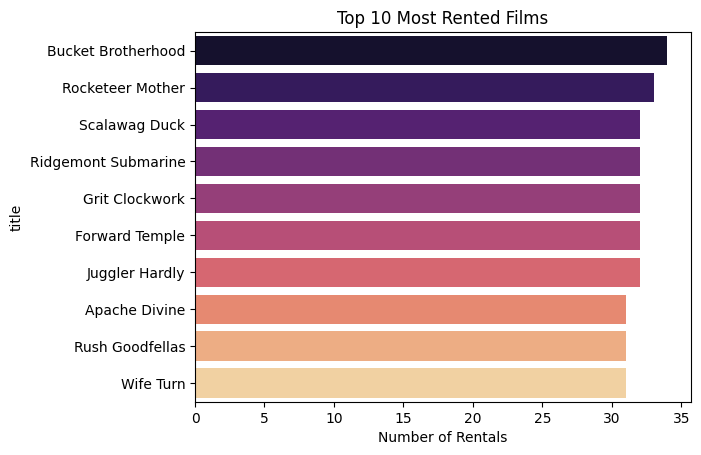

In [7]:
top_films = fact_rental.groupby('title').size().sort_values(ascending=False).head(10)
sns.barplot(x=top_films.values, y=top_films.index, palette='magma')
plt.title("Top 10 Most Rented Films")
plt.xlabel("Number of Rentals")
plt.show()


C:\Users\Meschac\AppData\Local\Temp\ipykernel_17232\1864507232.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  yield_by_category = fact_rental.groupby('category')['rental_yield'].mean().sort_values(ascending=False)
C:\Users\Meschac\AppData\Local\Temp\ipykernel_17232\1864507232.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=yield_by_category.values, y=yield_by_category.index, palette='viridis')


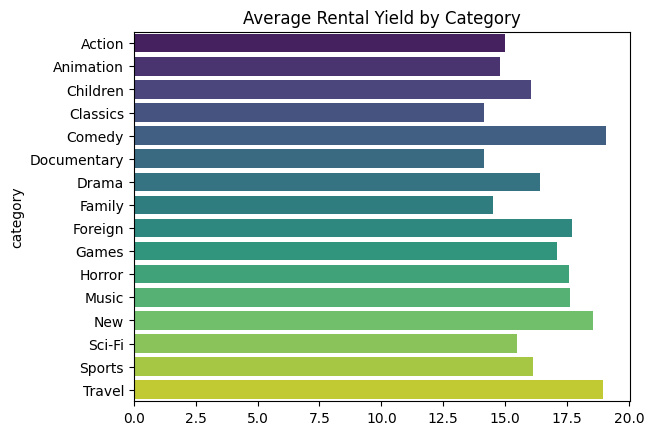

In [8]:
yield_by_category = fact_rental.groupby('category')['rental_yield'].mean().sort_values(ascending=False)
sns.barplot(x=yield_by_category.values, y=yield_by_category.index, palette='viridis')
plt.title("Average Rental Yield by Category")
plt.show()


C:\Users\Meschac\AppData\Local\Temp\ipykernel_17232\1047433513.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rentals_per_store.index, y=rentals_per_store.values, palette='coolwarm')


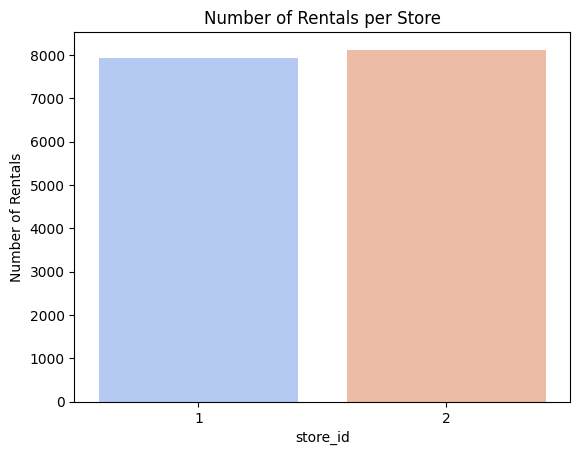

C:\Users\Meschac\AppData\Local\Temp\ipykernel_17232\1047433513.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=yield_per_store.index, y=yield_per_store.values, palette='plasma')


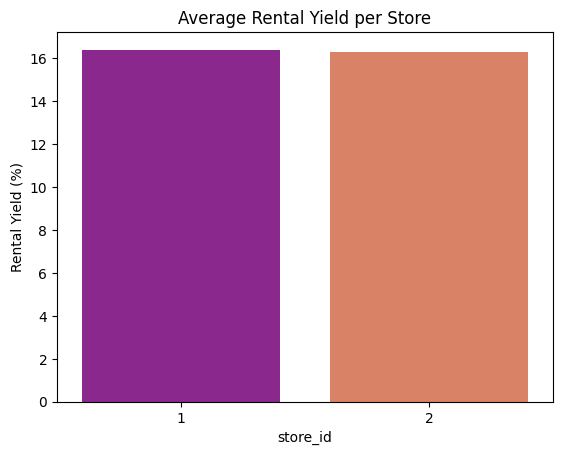

In [9]:
# Nombre de locations par store
rentals_per_store = fact_rental.groupby('store_id').size()
sns.barplot(x=rentals_per_store.index, y=rentals_per_store.values, palette='coolwarm')
plt.title("Number of Rentals per Store")
plt.ylabel("Number of Rentals")
plt.show()

# Rendement moyen par store
yield_per_store = fact_rental.groupby('store_id')['rental_yield'].mean()
sns.barplot(x=yield_per_store.index, y=yield_per_store.values, palette='plasma')
plt.title("Average Rental Yield per Store")
plt.ylabel("Rental Yield (%)")
plt.show()


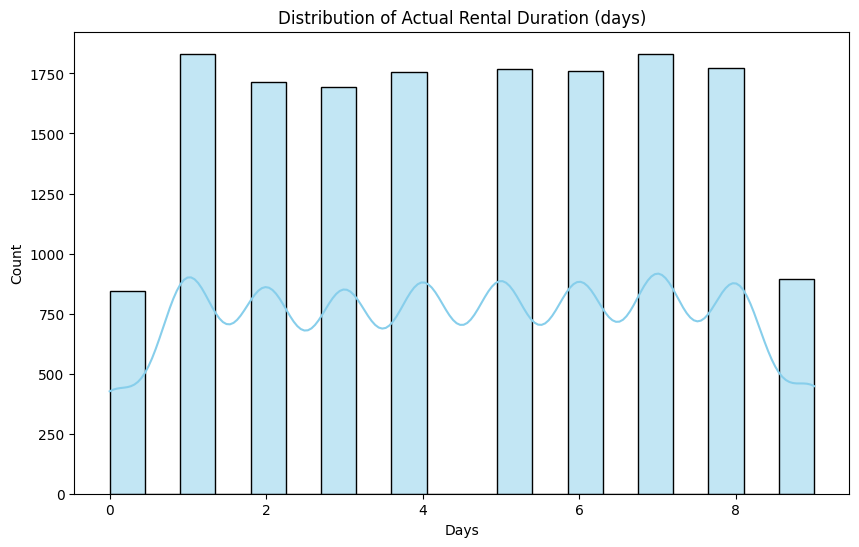

In [10]:
plt.figure(figsize=(10,6))
sns.histplot(fact_rental['actual_rental_duration'], bins=20, kde=True, color='skyblue')
plt.title("Distribution of Actual Rental Duration (days)")
plt.xlabel("Days")
plt.ylabel("Count")
plt.show()


C:\Users\Meschac\AppData\Local\Temp\ipykernel_17232\669219774.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  store_category = fact_rental.groupby(['store_id','category']).size().unstack(fill_value=0)


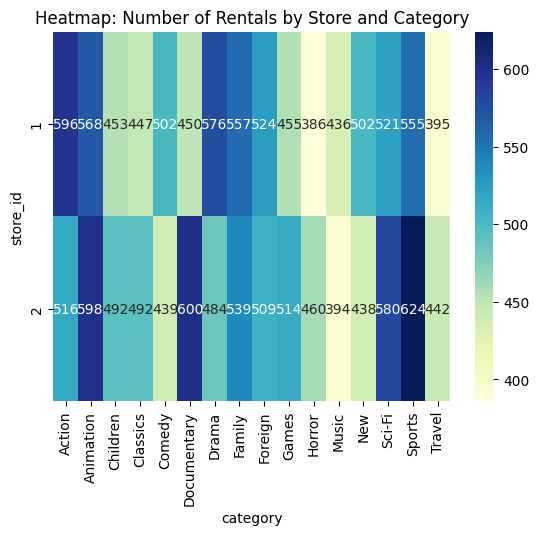

In [11]:
store_category = fact_rental.groupby(['store_id','category']).size().unstack(fill_value=0)
sns.heatmap(store_category, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Heatmap: Number of Rentals by Store and Category")
plt.show()


C:\Users\Meschac\AppData\Local\Temp\ipykernel_17232\4263441681.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_yield_films.values, y=top_yield_films.index, palette='magma')


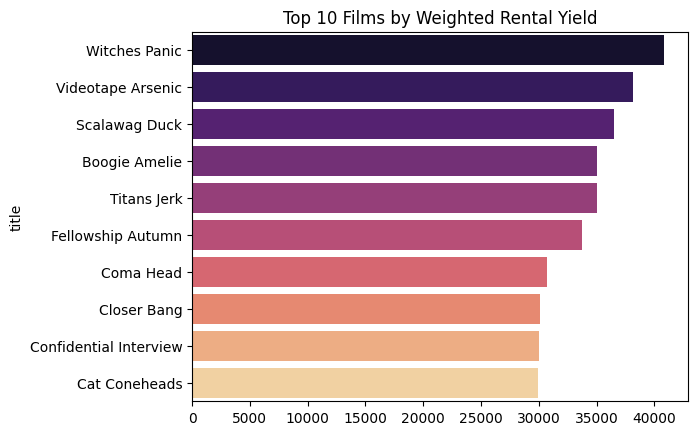

In [12]:
fact_rental['weighted_yield'] = fact_rental['rental_yield'] * fact_rental.groupby('film_id')['film_id'].transform('count')
top_yield_films = fact_rental.groupby('title')['weighted_yield'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_yield_films.values, y=top_yield_films.index, palette='magma')
plt.title("Top 10 Films by Weighted Rental Yield")
plt.show()


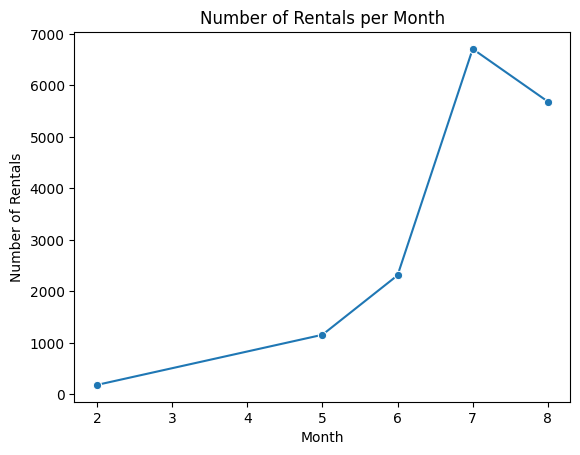

In [13]:
fact_rental['month'] = fact_rental['rental_date'].dt.month
rentals_per_month = fact_rental.groupby('month').size()
sns.lineplot(x=rentals_per_month.index, y=rentals_per_month.values, marker='o')
plt.title("Number of Rentals per Month")
plt.xlabel("Month")
plt.ylabel("Number of Rentals")
plt.show()


In [15]:
print(dim_film.columns)

Index(['film_id', 'title', 'category', 'rental_rate', 'length',
       'replacement_cost', 'rating', 'category_id'],
      dtype='object')
